In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/Animal Dataset.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df = pd.read_csv('/content/Animal Dataset.csv')

In [ ]:
df.head()

,Animal,Height (cm),Weight (kg),Color,Lifespan (years),Diet,Habitat,Predators,Average Speed (km/h),Countries Found,Conservation Status,Family,Gestation Period (days),Top Speed (km/h),Social Structure,Offspring per Birth
0,Aardvark,105-130,40-65,Grey,20-30,Insectivore,"Savannas, Grasslands","Lions, Hyenas",40,Africa,Least Concern,Orycteropodidae,210-240,40,Solitary,1
1,Aardwolf,40-50,8-14,Yellow-brown,10-12,Insectivore,"Grasslands, Savannas","Lions, Leopards",24-30,Eastern and Southern Africa,Least Concern,Hyaenidae,90,40,Solitary,2-5
2,African Elephant,270-310,2700-6000,Grey,60-70,Herbivore,"Savannah, Forest","Lions, Hyenas",25,Africa,Vulnerable,Elephantidae,640-660,40,Herd-based,1
3,African Lion,80-110,120-250,Tan,10-14,Carnivore,"Grasslands, Savannas","Hyenas, Crocodiles",58,Africa,Vulnerable,Felidae,98-105,80,Group-based,2-4 (usually)
4,African Wild Dog,75-80,18-36,Multicolored,10-12,Carnivore,Savannahs,"Lions, Hyenas",56,Sub-Saharan Africa,Endangered,Canidae,70,56,Group-based,10-12


In [ ]:
df.isnull().sum()

Animal                     0
Height (cm)                0
Weight (kg)                0
Color                      0
Lifespan (years)           0
Diet                       0
Habitat                    0
Predators                  0
Average Speed (km/h)       0
Countries Found            0
Conservation Status        0
Family                     0
Gestation Period (days)    0
Top Speed (km/h)           0
Social Structure           0
Offspring per Birth        0
dtype: int64

In [ ]:
!pip install catboost

In [ ]:
!
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import catboost as cb

In [ ]:
le = LabelEncoder()
df['Animal'] = le.fit_transform(df['Animal'])
df['Height (cm)'] = le.fit_transform(df['Height (cm)'])
df['Weight (kg)'] = le.fit_transform(df['Weight (kg)'])
df['Color'] = le.fit_transform(df['Color'])
df['Lifespan (years)'] = le.fit_transform(df['Lifespan (years)'])
df['Diet'] = le.fit_transform(df['Diet'])
df['Habitat'] = le.fit_transform(df['Habitat'])
df['Predators'] = le.fit_transform(df['Predators'])
df['Average Speed (km/h)'] = le.fit_transform(df['Average Speed (km/h)'])
df['Countries Found'] = le.fit_transform(df['Countries Found'])
df['Conservation Status'] = le.fit_transform(df['Conservation Status'])
df['Gestation Period (days)'] = le.fit_transform(df['Gestation Period (days)'])
df['Family'] = le.fit_transform(df['Family'])
df['Social Structure'] = le.fit_transform(df['Social Structure'])
df['Offspring per Birth'] = le.fit_transform(df['Offspring per Birth'])
df['Top Speed (km/h)'] = le.fit_transform(df['Top Speed (km/h)'])

In [ ]:
X= df.drop(['Lifespan (years)'],axis=1)
y = df['Lifespan (years)']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
xgm = xg.XGBRegressor()
xgm.fit(X_train,y_train)
xgm.score(X_test,y_test)

-0.08905409120361862

In [ ]:
cbm = cb.CatBoostRegressor(verbose=0)
cbm.fit(X_train,y_train)
cbm.score(X_test,y_test)

0.06045359781398274

In [ ]:
y_pred = cbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

In [ ]:
print(mse)

739.3073218486213


In [ ]:
!pip install optuna
import optuna

In [ ]:
 def objective(trial):

    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-6, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
    }

    # Initialize and train CatBoostRegressor with suggested hyperparameters
    model = cb.CatBoostRegressor(**params, verbose=False)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))

    # Evaluate the model using mean squared error
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # You can adjust n_trials as needed

# Get the best hyperparameters
best_params = study.best_params
best_mse = study.best_value

print(f"Best Hyperparameters: {best_params}")
print(f"Best Mean Squared Error: {best_mse}")

# Train a final model with the best hyperparameters
final_model = cb.CatBoostRegressor(**best_params, verbose=False)
final_model.fit(X_train, y_train)  # Train on the entire dataset

[I 2023-10-07 12:16:05,162] A new study created in memory with name: no-name-30ac4589-1dd1-4041-bd50-746596907302
[I 2023-10-07 12:16:05,684] Trial 0 finished with value: 716.7638875843802 and parameters: {'iterations': 812, 'learning_rate': 0.29204587283714245, 'depth': 4, 'l2_leaf_reg': 0.18654706993012957, 'bagging_temperature': 0.28742718453096605}. Best is trial 0 with value: 716.7638875843802.
[I 2023-10-07 12:16:06,518] Trial 1 finished with value: 731.5873630106694 and parameters: {'iterations': 217, 'learning_rate': 0.0803245208090863, 'depth': 8, 'l2_leaf_reg': 0.007163870375523045, 'bagging_temperature': 0.20289715800886532}. Best is trial 0 with value: 716.7638875843802.
[I 2023-10-07 12:16:08,357] Trial 2 finished with value: 695.915419476913 and parameters: {'iterations': 407, 'learning_rate': 0.1040516193363673, 'depth': 8, 'l2_leaf_reg': 0.0007931066897871959, 'bagging_temperature': 0.6070295934749415}. Best is trial 2 with value: 695.915419476913.
[I 2023-10-07 12:16:1

Best Hyperparameters: {'iterations': 691, 'learning_rate': 0.2980633069002567, 'depth': 4, 'l2_leaf_reg': 0.00549166422679316, 'bagging_temperature': 0.3401046805784017}
Best Mean Squared Error: 610.902725504503


In [ ]:
p = {'iterations': 918, 'learning_rate': 0.2840499013123191, 'depth': 5, 'l2_leaf_reg': 8.187774334259156e-06, 'bagging_temperature': 0.8263909377164824}

In [ ]:
cbm = cb.CatBoostRegressor(**p,verbose=0)
cbm.fit(X_train,y_train)
cbm.score(X_test,y_test)

0.08014734682160018

In [ ]:
y_pred = cbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

723.810766487327


In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# instantiate the DecisionTreeClassifier model with criterion gini index

clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)


# fit the model
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [ ]:
y_pred_gini = clf_gini.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.0976


In [ ]:
y_pred_train_gini = clf_gini.predict(X_train)

y_pred_train_gini

array([ 7, 19,  7,  7,  7,  7,  7,  7, 19,  7, 19,  7, 19, 26,  7, 19, 19,
       19,  7,  7,  7,  7,  7,  7,  7, 19,  7, 19,  7,  7, 19, 19,  7, 19,
        7, 19,  7,  7, 19, 19, 19, 19, 19,  7,  7,  7, 27,  7, 19, 92, 19,
       26, 19, 19, 19, 19,  7, 26, 19,  7,  7, 19,  7,  7,  7,  7, 19,  7,
        7, 19, 26,  7, 26, 19,  7, 84,  7,  7,  7,  7,  7, 19,  7, 19, 92,
       19, 92, 26, 19, 19,  7, 19,  7,  7, 19, 19,  7,  7, 26, 19,  7,  7,
        7,  7, 19,  7, 19,  7, 92,  7,  7,  7, 19, 19,  7, 19,  7, 19, 19,
        7, 19,  7, 19,  7,  7,  7,  7, 27,  7, 19,  7, 19, 19, 19,  7, 19,
        7,  7,  7, 27, 26,  7, 19, 19, 27,  7,  7,  7, 19,  7, 26,  7,  7,
        7, 19, 26, 19, 19,  7,  7,  7, 19, 19,  7])

In [ ]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))

Training-set accuracy score: 0.2134


In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf_gini.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_gini.score(X_test, y_test)))

Training set score: 0.2134
Test set score: 0.0976


In [ ]:
import matplotlib.pyplot as plt

[Text(0.5909090909090909, 0.875, 'x[12] <= 69.5\ngini = 0.971\nsamples = 164\nvalue = [1, 1, 5, 3, 1, 1, 17, 1, 1, 2, 2, 2, 1, 1\n1, 2, 9, 1, 2, 2, 1, 1, 7, 9, 1, 1, 1, 2\n1, 1, 1, 1, 3, 1, 3, 2, 1, 1, 2, 1, 1, 1\n1, 1, 5, 3, 1, 3, 1, 1, 2, 2, 1, 2, 1, 1\n1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2\n7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4]'),
 Text(0.36363636363636365, 0.625, 'x[14] <= 1.5\ngini = 0.97\nsamples = 159\nvalue = [1, 1, 5, 3, 1, 1, 17, 1, 1, 2, 2, 2, 1, 1\n1, 2, 9, 1, 2, 2, 1, 1, 7, 9, 1, 1, 1, 2\n1, 1, 1, 1, 3, 1, 3, 2, 1, 1, 2, 1, 1, 1\n1, 1, 5, 3, 1, 3, 1, 1, 2, 2, 1, 2, 1, 1\n1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2\n7, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]'),
 Text(0.18181818181818182, 0.375, 'x[5] <= 78.5\ngini = 0.958\nsamples = 64\nvalue = [0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 1, 0, 1, 1\n0, 2, 8, 1, 1, 0, 1, 1, 1, 6, 1, 1, 1, 0\n1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 2, 1, 1, 0\n0, 1, 3, 2, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0\n0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2\n2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

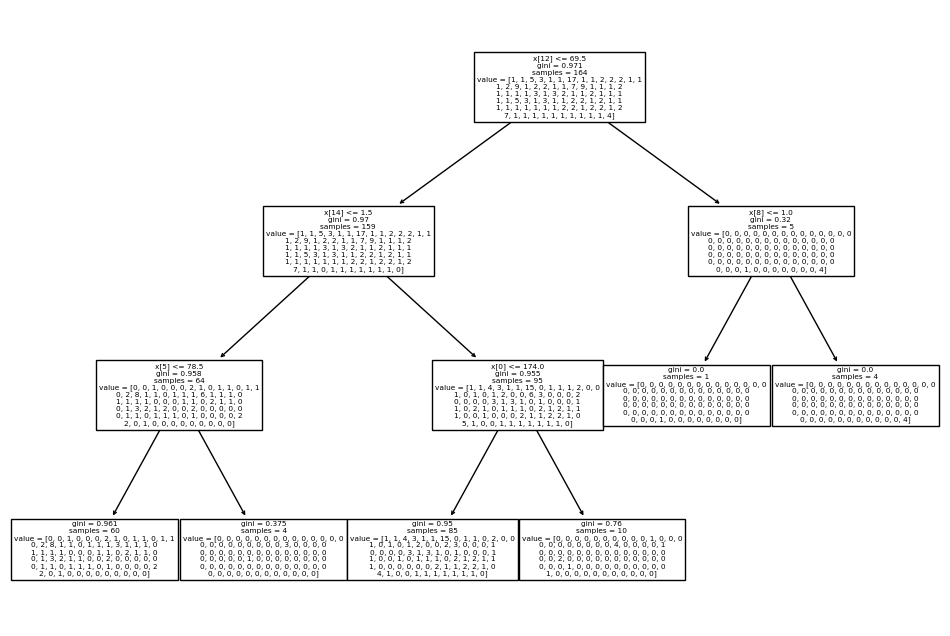

In [ ]:
plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(clf_gini.fit(X_train, y_train))

In [ ]:
# instantiate the DecisionTreeClassifier model with criterion entropy

clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)


# fit the model
clf_en.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [ ]:
y_pred_en = clf_en.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))

Model accuracy score with criterion entropy: 0.0976


In [ ]:
y_pred_train_en = clf_en.predict(X_train)

y_pred_train_en

array([ 7, 19, 92, 19,  5,  7,  7,  7, 56, 92,  7,  3,  7,  7,  3, 19, 19,
        7,  7, 92,  7, 92,  7,  3,  7, 19, 92, 19,  7, 92, 56,  7, 19,  7,
        7,  7,  7, 56, 56,  3,  7,  7,  7, 92,  3,  7,  7,  7,  3, 92,  7,
        7,  7, 19, 19,  7,  3,  7, 19,  7,  7,  7,  7,  5,  5,  7,  5, 92,
        7, 56,  7, 92,  7, 19,  7,  5,  7,  7,  7,  7, 92, 19, 92, 19, 92,
        7,  5, 19, 19, 19,  7, 19,  7,  5,  5,  3,  3,  7, 92,  7,  7,  7,
        3,  7,  7, 92, 56,  3, 92,  7,  3,  3,  7, 56,  7,  7,  7,  3, 19,
        7, 56,  7, 19,  3,  7, 92, 19, 19, 92, 56,  7,  3,  7, 19,  3, 19,
        7,  3,  5, 19,  7,  5,  7, 56, 19, 19,  7,  3, 56,  3,  7,  7,  3,
        5, 56,  7, 56, 19,  7, 19,  5, 19, 19, 92])

In [ ]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_en)))

Training-set accuracy score: 0.1890


In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf_en.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_en.score(X_test, y_test)))

Training set score: 0.1890
Test set score: 0.0976


[Text(0.5, 0.875, 'x[10] <= 48.5\nentropy = 5.804\nsamples = 164\nvalue = [1, 1, 5, 3, 1, 1, 17, 1, 1, 2, 2, 2, 1, 1\n1, 2, 9, 1, 2, 2, 1, 1, 7, 9, 1, 1, 1, 2\n1, 1, 1, 1, 3, 1, 3, 2, 1, 1, 2, 1, 1, 1\n1, 1, 5, 3, 1, 3, 1, 1, 2, 2, 1, 2, 1, 1\n1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2\n7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4]'),
 Text(0.25, 0.625, 'x[11] <= 118.5\nentropy = 4.969\nsamples = 84\nvalue = [0, 1, 5, 3, 1, 1, 14, 1, 0, 1, 0, 2, 0, 0\n0, 0, 3, 0, 0, 2, 0, 1, 6, 5, 0, 1, 1, 0\n1, 1, 1, 0, 2, 0, 1, 0, 0, 1, 0, 0, 1, 1\n0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0\n0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 0, 0, 0, 1\n4, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]'),
 Text(0.125, 0.375, 'x[11] <= 41.5\nentropy = 4.184\nsamples = 51\nvalue = [0, 1, 0, 1, 0, 1, 11, 1, 0, 1, 0, 0, 0, 0\n0, 0, 2, 0, 0, 2, 0, 1, 6, 5, 0, 1, 1, 0\n0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1\n0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0\n0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1\n3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.0625, 0.125, 'e

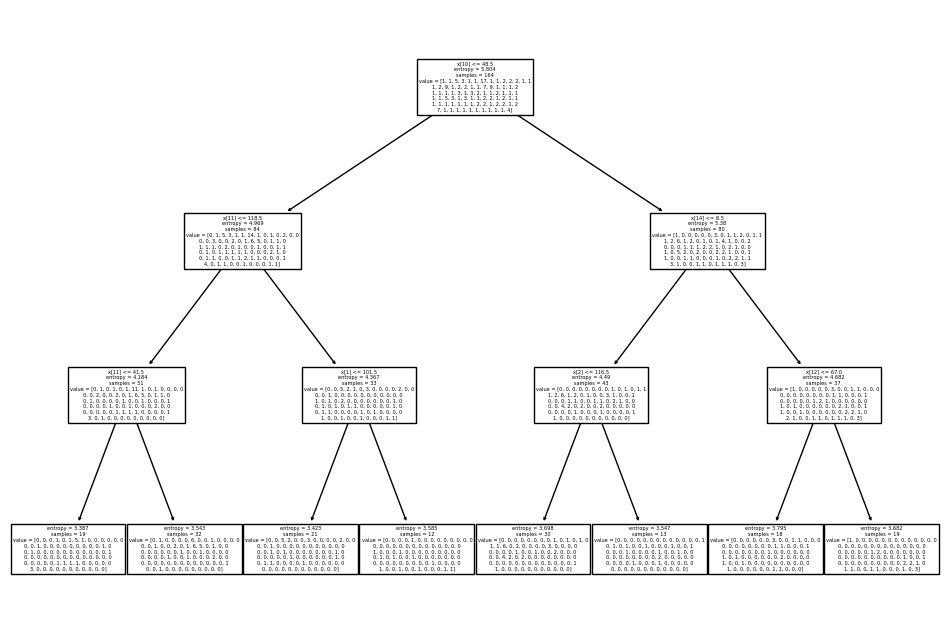

In [ ]:
plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(clf_en.fit(X_train, y_train))

In [ ]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_en)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_en))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           7       0.16      0.75      0.26         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         2
          25       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         3
          27       0.00      0.00      0.00         2
          31       0.00      0.00      0.00         4
          36       0.00      0.00      0.00         1
          38       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          41       0.00      0.00      0.00         1
          42       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#logistic regresion


In [ ]:
# fitting data to model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

lr = LogisticRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

lr_train_acc = accuracy_score(y_train, lr.predict(X_train))
lr_test_acc = accuracy_score(y_test, y_pred)

print(f"Training Accuracy of Logistic Regression Model is {lr_train_acc}")
print(f"Test Accuracy of Logistic Regression Model is {lr_test_acc}")

Training Accuracy of Logistic Regression Model is 0.8658536585365854
Test Accuracy of Logistic Regression Model is 0.07317073170731707


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# confusion matrix

confusion_matrix(y_test, y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         2
          22       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         1
          26       0.33      0.33      0.33         3
          27       0.00      0.00      0.00         2
          31       0.00      0.00      0.00         4
          35       0.00      0.00      0.00         0
          36       0.00      0.00      0.00         1
          38       0.00      0.00      0.00         1
          39       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
#K Neighbors Classifier (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

knn_train_acc = accuracy_score(y_train, knn.predict(X_train))
knn_test_acc = accuracy_score(y_test, y_pred)

print(f"Training Accuracy of KNN Model is {knn_train_acc}")
print(f"Test Accuracy of KNN Model is {knn_test_acc}")

Training Accuracy of KNN Model is 0.3353658536585366
Test Accuracy of KNN Model is 0.07317073170731707


In [ ]:
# confusion matrix

confusion_matrix(y_test, y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [ ]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.14      1.00      0.25         1
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.09      0.25      0.13         4
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         1
          26       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
#Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

dtc_train_acc = accuracy_score(y_train, dtc.predict(X_train))
dtc_test_acc = accuracy_score(y_test, y_pred)

print(f"Training Accuracy of Decision Tree Model is {dtc_train_acc}")
print(f"Test Accuracy of Decision Tree Model is {dtc_test_acc}")

Training Accuracy of Decision Tree Model is 1.0
Test Accuracy of Decision Tree Model is 0.07317073170731707


In [ ]:
# confusion matrix

confusion_matrix(y_test, y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.25      0.25      0.25         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         2
          22       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         3
          27       0.00      0.00      0.00         2
          31       0.00      0.00      0.00         4
          33       0.00      0.00      0.00         0
          36       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
#Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rand_clf = RandomForestClassifier(criterion = 'gini', max_depth = 3, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 4, n_estimators = 180)
rand_clf.fit(X_train, y_train)

y_pred = rand_clf.predict(X_test)

rand_clf_train_acc = accuracy_score(y_train, rand_clf.predict(X_train))
rand_clf_test_acc = accuracy_score(y_test, y_pred)

print(f"Training Accuracy of Random Forest Model is {rand_clf_train_acc}")
print(f"Test Accuracy of Random Forest Model is {rand_clf_test_acc}")

Training Accuracy of Random Forest Model is 0.27439024390243905
Test Accuracy of Random Forest Model is 0.14634146341463414


In [ ]:
# confusion matrix

confusion_matrix(y_test, y_pred)

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

In [ ]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           7       0.12      1.00      0.22         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         2
          25       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         3
          27       0.00      0.00      0.00         2
          31       0.00      0.00      0.00         4
          36       0.00      0.00      0.00         1
          38       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          41       0.00      0.00      0.00         1
          42       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
from sklearn.model_selection import train_test_split

train, val_train, test, val_test = train_test_split(X, y, test_size = 0.5, random_state = 355)

In [ ]:
# let's split the training set again into training and test dataset

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size = 0.2, random_state = 355)

In [ ]:
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']
scores = [lr_test_acc, knn_test_acc,  dtc_test_acc, rand_clf_test_acc]
models = pd.DataFrame({'Model' : models, 'Score' : scores})


models.sort_values(by = 'Score', ascending = False)

,Model,Score
3,Random Forest,0.146341
0,Logistic Regression,0.073171
1,KNN,0.073171
2,Decision Tree,0.073171


In [ ]:
import seaborn as sns

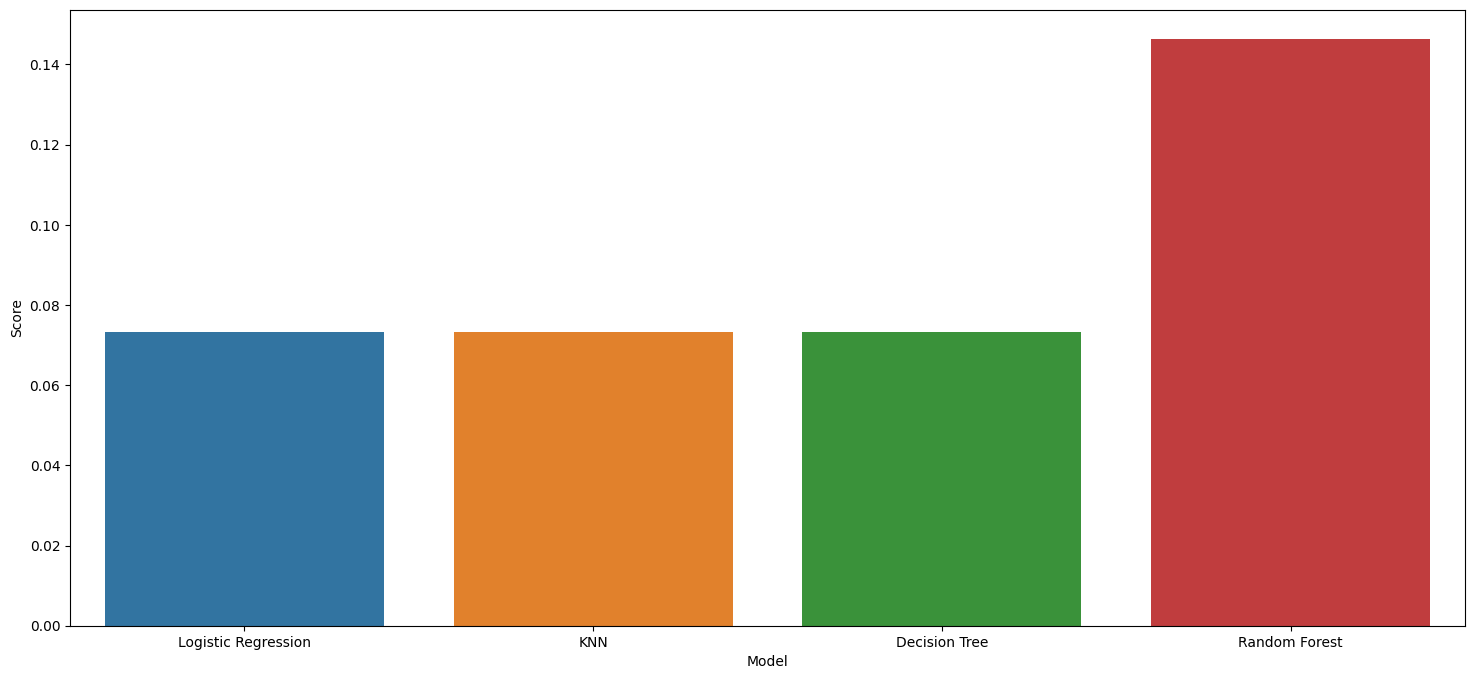

In [ ]:
plt.figure(figsize = (18, 8))

sns.barplot(x = 'Model', y = 'Score', data = models)
plt.show()